In [1]:
import sys
sys.path.insert(0, '../')
from util import util
import numpy as np
import scipy.stats as st

import matplotlib.pyplot as plt

from scipy.optimize import minimize
import pymc3 as pm
import pandas as pd
import seaborn as sns
import pymc3.sampling as sampling
import theano.tensor as tt

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Portfolio optimisation

Demiguel Nogalwes 2009 ran a model as followed:

We will assume the true asset-return distribution is given as $$G = 99\% \times \mathcal{N}(\mu,\Sigma) + 1\% \times D $$
where $D = \mathcal{N}(\mu_d,\Sigma_d)$ where $\Sigma_d=\Sigma$

Lim et al used the follow model:
$$ \mathbf{X} \sim \mathcal{N}(\mathbf{\mu},\mathbf{\Sigma})$$

</p>Given $N$ risky assets the mean variance portfolio is the solution to the problem 
$$\min_w \mathbf{w}^T\hat{\Sigma}\mathbf{w} - \frac{1}{\gamma}\hat{\mathbf{\mu}}^T\mathbf{w}$$ 
$$s.t. \mathbf{w}^T\mathbf{e} = 1 $$</p>

<p> We also seek to find the minimum-variance porfolio 
    $$\min_w \mathbf{w}^T\hat{\Sigma}\mathbf{w}$$
    $$s.t. \mathbf{w}^T\mathbf{e} = 1 $$</p>

In [2]:
mu = np.array([26.11 , 25.21 , 28.90 , 28.68 , 24.18])
covar = np.array([[3.715 , 3.730 , 4.420 , 3.606 , 3.673],
                 [3.730 , 3.908 , 4.943 , 3.732 , 3.916],
                [4.420 , 4.943 , 8.885 , 4.378 , 5.010],
                  [3.606 , 3.732 , 4.378 , 3.930 , 3.789],
                  [3.673 , 3.916 , 5.010 , 3.789 , 4.027]])
model = st.multivariate_normal(mean=mu,cov=covar)

In [3]:
def mean_variance(weights,mean,cov,gamma,average=False):
    var = np.dot(np.dot(weights,cov),weights)
    mean = 1.0/gamma*np.dot(mean,weights)
    if average:
        return np.mean(var-mean,axis=0)
    else: 
        return var-mean

In [4]:
def sum_weights(weights):
    return np.sum(weights)-1

In [5]:
init_weights = np.ones((5))/5
gamma = [0.1,1.0,5.0,10]
N = [50,100,200]
constraints = [{'type':'eq','fun':sum_weights}]
n_iter = 1000
df = pd.DataFrame(columns=['w_star','method','gamma','N'])

In [6]:
def mle_mv_gaussian(mean_est,cov_est,gamma,average=False):
    res = minimize(mean_variance,init_weights,args=(mean_est,cov_est,gamma,
                                                    average),
                  constraints=constraints,
                  bounds=[(0,None)]*5)
    return res.x

In [7]:
def fix_string(x):
    return np.array([float(z) for z in x[1:-1].split(' ') if z is not ""])

In [8]:
df = pd.read_csv("portfolio_opt.csv",index_col=0)

In [9]:
df['w_star'] = df['w_star'].apply(lambda x:fix_string(x))
df['expected_return'] = df['w_star'].apply(lambda x:np.dot(mu,x))

In [10]:
df[df['method']=='True']

,w_star,method,gamma,N,expected_return
3000,"[3.97205465e-16, 0.0, 0.240396728, 0.759603272...",True,0.1,200,28.732887
6001,"[1.94289029e-16, 0.0, 0.0, 1.0, 1.16226473e-16]",True,1.0,200,28.680000
9002,"[0.360456875, 0.0948441679, 4.33680869e-17, 0....",True,5.0,200,27.424517
12003,"[0.282611182, 0.226234045, 5.55111512e-17, 0.2...",True,10.0,200,26.256723


In [11]:
gamma_df = df[df['gamma']==1.0]

/home/harrison/.virtualenvs/python3/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


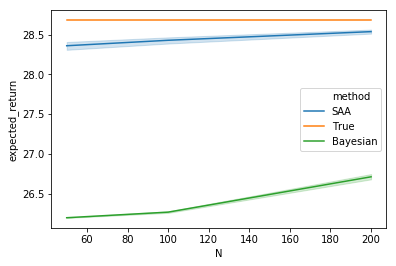

In [12]:
ax = sns.lineplot(x=gamma_df['N'], y=gamma_df['expected_return'], 
                  hue=gamma_df['method'])
plt.plot(N,[gamma_df[gamma_df['method']=='True']['expected_return'].iloc[0]]*3)

## Using Bayesian inference

We use a normal-inversewishart prior on the mean and covariance of the multivariate gaussian.
$$p(\Sigma)\sim \mathcal{W}^{-1}(\mathbf{5I},5)$$
$$p(\mu|\Sigma)\sim \mathcal{N}([27,27,27,27,27],\Sigma)$$

In [13]:
mu0 = np.array([27]*5)
m = 1
Psi = 5*np.eye(5)
nu0 = 5

In [14]:
def bayesian_portfolio(samples,n_samples=2000):
    # known scaling
    with pm.Model() as model:
        #sd_dist = pm.HalfCauchy.dist(beta=2.5)
        sd_dist = pm.Gamma.dist(alpha=7.5,beta=1.0)
        chol_dist = pm.LKJCholeskyCov('chol',n=5,eta=2,
                                      sd_dist=sd_dist)
        chol = pm.expand_packed_triangular(5, chol_dist, lower=True)
        mu_dist = pm.MvNormal('mu',chol=chol, mu=mu0,shape=5)
        observed = pm.MvNormal('obs',mu=mu_dist,chol=chol,observed=samples)
        Sigma = pm.Deterministic('cov', chol.dot(chol.T))
        # Using Metropolis Hastings Sampling
        #step = pm.HamiltonianMC()
        step = pm.Metropolis()

        # Sample from the posterior using the sampling method
        trace = pm.sample(n_samples,step=step,njobs=4,progressbar=False,cores=4)
        
        #new_samples = np.reshape(sampling.sample_ppc(trace,samples=n_samples,
        #            model=model,
        #            progressbar=False)['obs'],(-1,5))    
    return trace

In [15]:
n_iter = 500

In [17]:
for j in range(len(gamma)):
    for l in range(n_iter):
        for i in range(len(N)):
            n = N[i]
            samples = model.rvs(n)
            sample_mean = np.mean(samples,axis=0)
            sample_cov = np.cov(samples.T)
            posterior_sigma_scale = Psi+n*sample_cov+m*n/(n+m)*np.dot(sample_mean-mu0,
                                                                  (sample_mean-mu0).T)
            posterior_sigma_nu = n+nu0
            post_invwish = st.invwishart(scale=posterior_sigma_scale,
                                        df=posterior_sigma_nu)
            cov_array = []
            mean_array = []
            for k in range(5000):

                cov_array.append(post_invwish.rvs())
                posterior_mean_mu = (n*sample_mean+m*mu0)/(m+n)
                #mean_wishart = posterior_sigma_scale/(posterior_sigma_nu-sample_mean.shape[0]-1)
                posterior_mean_sigma = 1/(m+n)*cov_array[k]
                mean_array.append(st.multivariate_normal.rvs(posterior_mean_mu,
                                                            posterior_mean_sigma))
            res = minimize(mean_variance,
                            init_weights,
                            args=(mean_array,
                                  cov_array,
                                    gamma[j],
                                     True),
                          constraints=constraints,
                          bounds=[(0,None)]*5)
            results = {'w_star': res.x,'method':'Bayesian_new','gamma':gamma[j],'N':N[i]}
            df = df.append(results,ignore_index=True)

KeyboardInterrupt: 

In [18]:
df['expected_return'] = df['w_star'].apply(lambda x:np.dot(
                                            mu,x))

In [ ]:
df.to_csv("portfolio_opt.csv")

In [29]:
gamma_df = df[df['gamma']==0.1][df['method']!='Bayes_new']

/home/harrison/.virtualenvs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


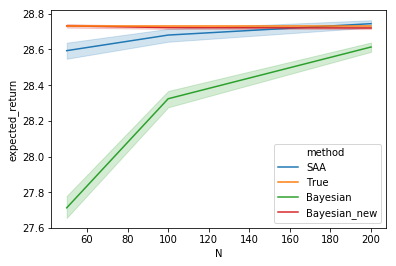

In [30]:
ax = sns.lineplot(x=gamma_df['N'], y=gamma_df['expected_return'], 
                  hue=gamma_df['method'])
plt.plot(N,[gamma_df[gamma_df['method']=='True']['expected_return'].iloc[0]]*3)

In [32]:
gamma_df[gamma_df['method']=='Bayesian_new']

,w_star,method,gamma,N,expected_return
24373,"[3.867461906281733e-13, 1.8147150449010496e-12...",Bayesian_new,0.1,50,28.680000
24374,"[7.458200723675645e-13, 2.5509316881056066e-12...",Bayesian_new,0.1,100,28.680000
24375,"[0.0, 0.0, 0.17756944021994242, 0.822430559908...",Bayesian_new,0.1,200,28.719065
24376,"[7.4718714253969e-12, 7.439052945635412e-12, 0...",Bayesian_new,0.1,50,28.689593
24377,"[0.0, 0.0, 0.1260858021562273, 0.8739141979412...",Bayesian_new,0.1,100,28.707739
24378,"[0.0, 0.0, 0.011944707148197063, 0.98805529288...",Bayesian_new,0.1,200,28.682628
24379,"[0.0, 0.0, 2.0921597787548762e-12, 1.000000000...",Bayesian_new,0.1,50,28.680000
24380,"[3.2452159846486905e-11, 3.6783044909541307e-1...",Bayesian_new,0.1,100,28.719494
24381,"[1.241260592383448e-12, 1.0616557214133118e-12...",Bayesian_new,0.1,200,28.710014
24382,"[0.0, 0.0, 0.06274691411329858, 0.937253085979...",Bayesian_new,0.1,50,28.693804
